# <font color='red'> problem </font>

You are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

The evaluation metric for this competition is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

RMSE is given by:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)}$$

where $y_i$ is the i observation and $\hat{y}_i$ is the prediction for that observation. 

In [150]:
import numpy as np
import pandas as pd
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import sys, os
from sklearn import preprocessing

#import pandas_profiling as pandas_profiling
plt.style.use('seaborn-whitegrid')



## <font color='blue'> step 1: read data and first atempt EDA </font>

In [198]:
def readInTaxi():
    """
    read in and clean dataset 
    return: df_train, df_test [pd.DataFrame]
    """
    df = pd.read_csv('../NYC_taxi/train_small.csv', nrows=50000, 
                           parse_dates=["pickup_datetime"])
    
    
    print('read in dataset -- training: ', df.shape)
       
    ## ==== step 1: missing values==================================
    df.dropna(how='any', axis='rows', inplace=True)

    
    
    ## === step 2: negative fareamount, constrained coordinates
    mask = (df['fare_amount'] > 0)
    df = df[mask]
    
    boxes = {'longitude': (-75, -73), 'latitude': (40, 42)}
    mask = (df['pickup_longitude'] >= boxes['longitude'][0])  & \
        (df['pickup_longitude'] <= boxes['longitude'][1]) & \
        (df['dropoff_longitude'] >= boxes['longitude'][0]) & \
        (df['dropoff_longitude'] <= boxes['longitude'][1]) & \
        (df['pickup_latitude'] >= boxes['latitude'][0]) & \
        (df['pickup_latitude'] <= boxes['latitude'][1]) & \
        (df['dropoff_latitude'] >= boxes['latitude'][0]) & \
        (df['dropoff_latitude'] <= boxes['latitude'][1])

    df = df[mask]
    print('*'*77)
    print('after drop dummies -- training: ', df.shape)

    return df
    
    

In [152]:
df =  pd.read_csv('../NYC_taxi/train_small.csv', nrows=50000)
df.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [153]:
df =  pd.read_csv('../NYC_taxi/train_small.csv', nrows=50000, 
                  parse_dates=["pickup_datetime"])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


### <font color='blue'> 1.1 Missing values </font>
- depends on the algorithm, impute or not
- XGBoost, light GBM: no need to impute (fillNA)

observation, okay, so far so good (for first 50000 samples)

In [154]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / len(df_train) * 100)\
            .sort_values(ascending=False)
missing = pd.concat([total, percent], keys=['total', 'percent'], axis=1)
missing

,total,percent
passenger_count,0,0.0
dropoff_latitude,0,0.0
dropoff_longitude,0,0.0
pickup_latitude,0,0.0
pickup_longitude,0,0.0
pickup_datetime,0,0.0
fare_amount,0,0.0
key,0,0.0


### <font color='blue'> 1.2 descriptive statistics </font>

what has been notices:
- minimal `fare_amount` is negative 
- maximum `pickup_lattitude` is super weired
- what's in `lattitude=0`? and `longitude=0`??

In [155]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [156]:
df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [157]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

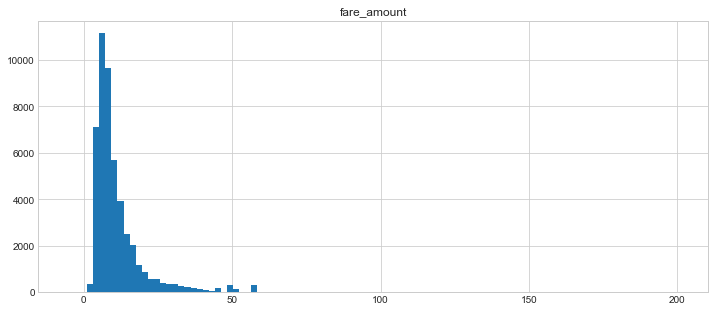

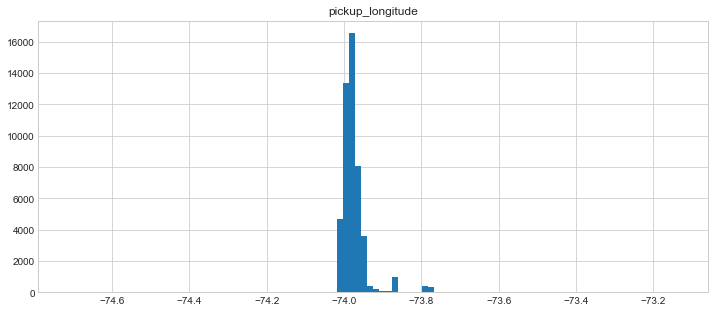

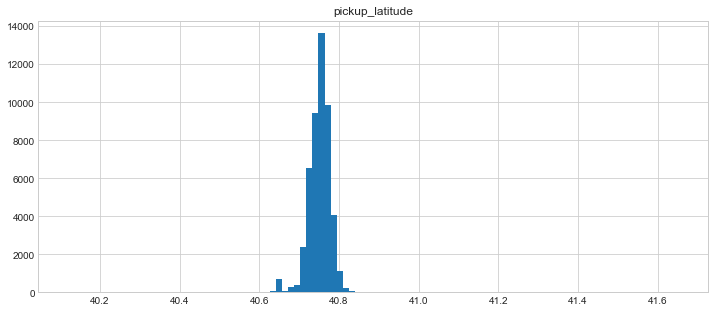

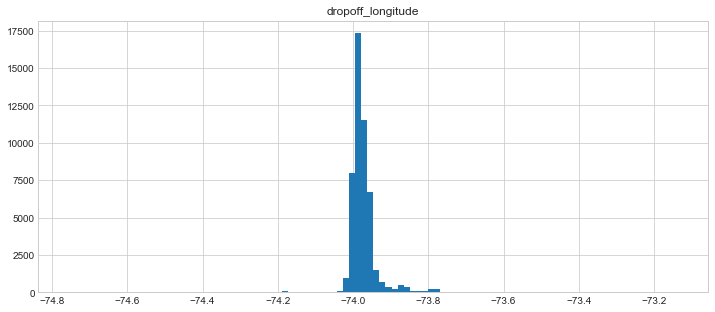

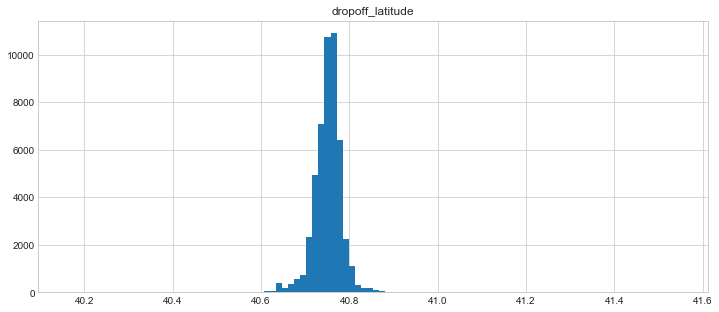

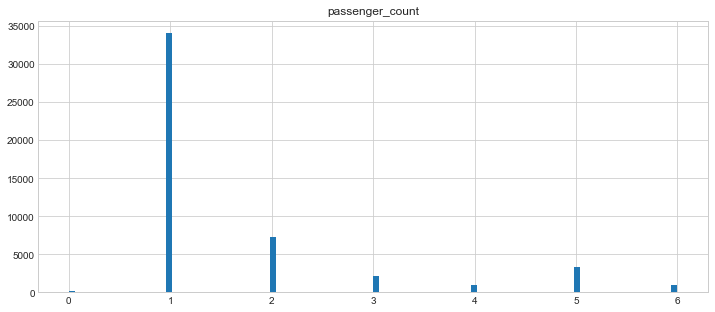

In [158]:
columns = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', \
           'dropoff_latitude', 'passenger_count']

for col in columns:
    fig = plt.figure(figsize=(12,5))
    #sns.kdeplot(df_train[col])
    df_train[col].hist(bins=100, figsize=(12,5))
    plt.title(col)
    
           

(-75, -73)

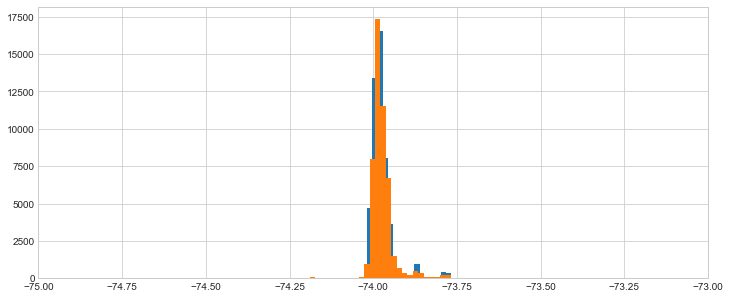

In [159]:
df_train['pickup_longitude'].hist(bins=100, figsize=(12,5))
plt.xlim(-74.5, -73)
df_train['dropoff_longitude'].hist(bins=100, figsize=(12,5))
plt.xlim(-75, -73)



(39, 45)

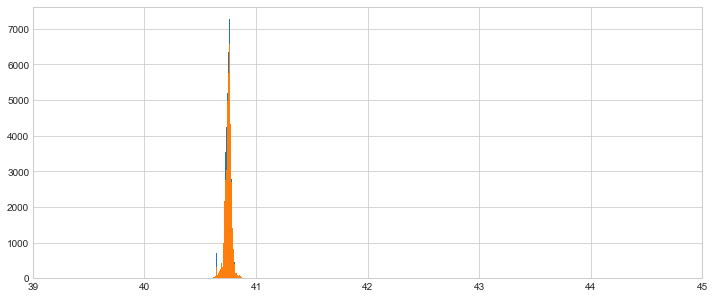

In [160]:

df_train['pickup_latitude'].hist(bins=200, figsize=(12, 5))
#plt.xlim(39,45)

df_train['dropoff_latitude'].hist(bins=200, figsize=(12, 5))
plt.xlim(39,45)

### <font color='blue'> 1.3 clean </font>

- remove missing data if any
- remove `fare_amount<0`
- constrain the `lattitude` and `longitude`, check NYC city coordinates (-74, 40.7)

- about 2% of the data is cleaned (that's okay!)

In [174]:
df.dropna(how='any', axis='rows', inplace=True)
boxes = {'longitude': (-75, -73), 'latitude': (40, 42)}
mask = (df['pickup_longitude'] >= boxes['longitude'][0])  & \
        (df['pickup_longitude'] <= boxes['longitude'][1]) & \
        (df['dropoff_longitude'] >= boxes['longitude'][0]) & \
        (df['dropoff_longitude'] <= boxes['longitude'][1]) & \
        (df['pickup_latitude'] >= boxes['latitude'][0]) & \
        (df['pickup_latitude'] <= boxes['latitude'][1]) & \
        (df['dropoff_latitude'] >= boxes['latitude'][0]) & \
        (df['dropoff_latitude'] <= boxes['latitude'][1])

df = df[mask]

In [176]:
df.shape

(48952, 17)

In [177]:
1 - 48952/50000

0.02095999999999998

### <font color='blue'> 1.4 visualization of the map </font>
[NYC taxi fare - data exploration](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration) for an super excellent EDA!

grap map using [open street map](https://www.openstreetmap.org/export#map=8/41.009/-73.998) with corrdinate [74.5_-72.8_40.5_41.8]

In [178]:
nyc_map =plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

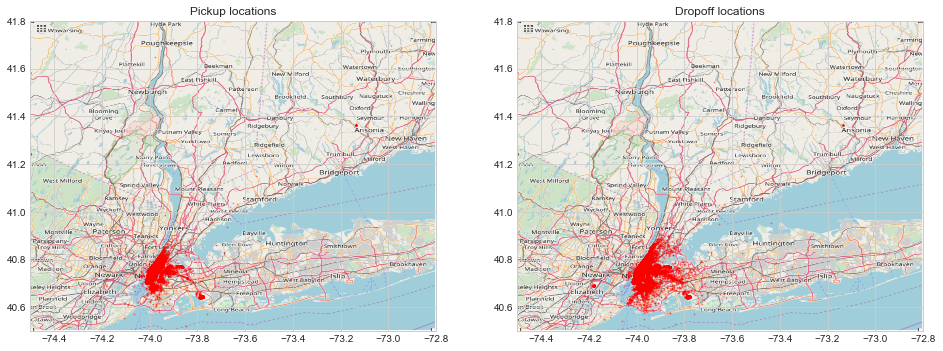

In [179]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
BB = (-74.5, -72.8, 40.5, 41.8)
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

## <font color='blue'>  step 2. feature engineering </font>
- distance 
- date (certainly) 
- important landmark (particularly airport)
- number of riders? (maybe not that important)? 



In [200]:
def distance(row):
    lat1 = row['dropoff_latitude']
    lat2 = row['pickup_latitude']
    lon1 = row['dropoff_longitude']
    lon2 = row['pickup_longitude']
    
    ## haversine formula https://en.wikipedia.org/wiki/Haversine_formula
    R = 6371
    dLat = np.pi/180 * (lat2 - lat1)
    dLon = np.pi/180 * (lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.pi/180*lat1) * np.cos(np.pi/180*lat2) * \
                + np.sin(dLon/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    return R * c

def distance_to_poi(row, poi):
    lat1 = row['pickup_latitude']
    lon1 = row['pickup_longitude']
    lon2 = poi[0]
    lat2 = poi[1]
    R = 6371
    dLat = np.pi/180 * (lat2 - lat1)
    dLon = np.pi/180 * (lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.pi/180*lat1) * np.cos(np.pi/180*lat2) * \
                + np.sin(dLon/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    return R * c

def feature_engineer(df):
    ## ==== step 1: calculate the point distance from pickup to dropoff=============
    df['distance'] = df.apply(distance, axis=1)
    
    ## ==== step 2: calculate the point distance to landmarks=============
    poi = {'nyc': (-74.006389, 40.714167),
       'jfk': (-73.782223, 40.644167),
       'ewr': (-74.175,  40.689722),
       'lga': (-73.87194, 40.774722)}
    
    
    for i in poi.keys():
        df['dist_to_{}'.format(i)] = df.apply(lambda x: distance_to_poi(x, poi[i]), axis=1)

    ## ==== step 3: clean the timestamp
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
    
    features = ['fare_amount',  'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour', 'day_of_week', 'month', 'year', 'distance',
       'dist_to_nyc', 'dist_to_jfk', 'dist_to_ewr', 'dist_to_lga']
    
    print('*'*77)
    print('after feature engineered -- training: ', df.shape)
    
    return df[features]
    

In [181]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,dist_to_nyc,dist_to_jfk,dist_to_ewr,dist_to_lga,hour,day_of_week,month,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,13.682776,10.050238,28.095531,6.377980,17,0,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,0.874177,21.084019,13.612839,14.040011,16,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,5.603867,21.336812,18.049555,9.449939,0,3,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.662007,19.909054,16.554573,10.747955,4,5,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,6.800795,20.859124,19.487039,8.131586,7,1,3,2010


### <font color='blue'> 2.1 distance </font>
- note that the distance is point to point, the actual one is longer 
- if there is a point of interest?

In [182]:
def distance(row):
    lat1 = row['dropoff_latitude']
    lat2 = row['pickup_latitude']
    lon1 = row['dropoff_longitude']
    lon2 = row['pickup_longitude']
    
    ## haversine formula https://en.wikipedia.org/wiki/Haversine_formula
    R = 6371
    dLat = np.pi/180 * (lat2 - lat1)
    dLon = np.pi/180 * (lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.pi/180*lat1) * np.cos(np.pi/180*lat2) * \
                + np.sin(dLon/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    return R * c

df['distance'] = df.apply(distance, axis=1)

In [183]:
def distance_to_poi(row, poi):
    lat1 = row['pickup_latitude']
    lon1 = row['pickup_longitude']
    lon2 = poi[0]
    lat2 = poi[1]
    R = 6371
    dLat = np.pi/180 * (lat2 - lat1)
    dLon = np.pi/180 * (lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.pi/180*lat1) * np.cos(np.pi/180*lat2) * \
                + np.sin(dLon/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    return R * c
    
## airport coordinates
poi = {'nyc': (-74.006389, 40.714167),
       'jfk': (-73.782223, 40.644167),
       'ewr': (-74.175,  40.689722),
       'lga': (-73.87194, 40.774722)}

for i in poi.keys():
    df['dist_to_{}'.format(i)] = df.apply(lambda x: distance_to_poi(x, poi[i]), axis=1)


###  <font color='blue'> 2.2 timestamp

In [184]:
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [185]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,dist_to_nyc,dist_to_jfk,dist_to_ewr,dist_to_lga,hour,day_of_week,month,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,13.682776,10.050238,28.095531,6.377980,17,0,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,0.874177,21.084019,13.612839,14.040011,16,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,5.603867,21.336812,18.049555,9.449939,0,3,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.662007,19.909054,16.554573,10.747955,4,5,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,6.800795,20.859124,19.487039,8.131586,7,1,3,2010


In [186]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'dist_to_nyc', 'dist_to_jfk',
       'dist_to_ewr', 'dist_to_lga', 'hour', 'day_of_week', 'month', 'year'],
      dtype='object')

In [193]:
df.shape

NameError: name 'df' is not defined

## <font color='blue'>  step 3. train-test splitting, modeling </font>

In [302]:
from sklearn.model_selection import train_test_split,  KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization


# linear model
def model_linear(x_train, y_train, x_test, y_test):   
    performance = pd.DataFrame(columns=['train_RMSE', 'test_RMSE'])
    features = ['distance', 'passenger_count', 'hour', 'day_of_week', 'month', \
           'dist_to_nyc', 'dist_to_jfk', 'dist_to_ewr', 'dist_to_lga']
    
    lr = LinearRegression()

    lr.fit(x_train[features], y_train)
       
    idx = 0
    y_pred = lr.predict(x_train[features])
    performance.loc[idx, 'train_RMSE'] = np.sqrt(mean_squared_error(y_train, y_pred))
        
    y_pred = lr.predict(x_test[features])
    performance.loc[idx, 'test_RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
        
    return performance
    

def model_lgbm(x_train, y_train, x_test, y_test, **params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])

    features = ['distance', 'passenger_count', 'hour', 'day_of_week', 'month', \
           'dist_to_nyc', 'dist_to_jfk', 'dist_to_ewr', 'dist_to_lga']
    x_train = x_train[features]
    x_test = x_test[features]
    
    
    # start training
    lgbm = LGBMRegressor(nthread=-1, silent=-1, verbose=-1,
                        **params)
    lgbm.fit(x_train, y_train, 
             eval_set=[(x_train, y_train), (x_test, y_test)],
             eval_metric = 'rmse', 
             verbose=False, 
             early_stopping_rounds=200)
    
    
    performance = pd.DataFrame(columns=['train_RMSE', 'test_RMSE'])
    idx = 0
    y_pred = lgbm.predict(x_train, num_iteration=lgbm.best_iteration_)
    performance.loc[idx, 'train_RMSE'] = np.sqrt(mean_squared_error(y_train, y_pred))
        
    y_pred = lgbm.predict(x_test, num_iteration=lgbm.best_iteration_)
    performance.loc[idx, 'test_RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
   
    
    return performance


def model_evaluate(**params):
    performance = model_lgbm(x_train, y_train, x_test, y_test, **params)
    return - performance['test_RMSE'].iloc[0]
  

def main():
    params =  {'num_leaves': (2, 50), 
          'max_depth': (2, 9),
          'min_split_gain': (.01, .03),
          'learning_rate': (.01, .02), 
          'reg_alpha': (.03, .05), 
          'reg_lambda': (.06, .08),             
          'colsample_bytree': (0.8, 1),       
          'subsample': (0.8, 1), 
          'min_child_weight': (38, 40)}

    bo = BayesianOptimization(model_evaluate, params)
    bo.maximize(init_points=5, n_iter=5)
    best_params = bo.res['max']['max_params']
    best_performance = model_lgbm(x_train, y_train, x_test, y_test, **best_params)
    return best_performance
    

params = {
    'num_leaves': 30,
    'max_depth': 10,
    'min_split_gain': 0.01,
    'learning_rate': 0.03,
    'reg_alpha': 0.04,
    'reg_lambda': 0.07, 
    'colsample_bytree': 1,
    'subsample': 1,
    'min_child_weight': 40
}

print('linear regression: ', model_linear(x_train, y_train, x_test, y_test))

print('lightGBM:' , model_lgbm(x_train, y_train, x_test, y_test, **params))

print('parameter optimized: ', main())

linear regression:    train_RMSE test_RMSE
0    6.01168   5.12806
lightGBM:   train_RMSE test_RMSE
0    4.57241    4.4223
Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
    1 | 00m00s |   -5.05578 |             0.8726 |          0.0149 |      5.0823 |            38.3745 |           0.0126 |      25.7995 |      0.0388 |       0.0617 |      0.8150 | 
    2 | 00m00s |   -5.34971 |             0.9268 |          0.0125 |      3.6939 |            39.1778 |           0.0127 |      31.9764 |      0.0486 |       0.0641 |      0.8008 | 
    3 | 00m00s |   -4.83436 |             0.9820 |          0.0159 |      8.8909 |            39.0508 |           0.0268 |      32.9587 

### <font color='blue'> 3.1 linear model as base-line </font>

In [218]:
df = readInTaxi()
df = feature_engineer(df)
print(df.shape)

#import sklearn.metrics.mean_squared_error as sk_rmse


x_train, x_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1),
                                                   df['fare_amount'], 
                                                   test_size = 0.3,
                                                   random_state = 42)

#del(df)

x_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,month,year,distance,dist_to_nyc,dist_to_jfk,dist_to_ewr,dist_to_lga
12292,-73.985939,40.748001,-74.005996,40.711315,4,11,3,12,2011,4.415539,4.138012,20.694583,17.200861,10.050568
22542,-73.975402,40.789532,-73.967961,40.800337,1,9,6,1,2010,1.354942,8.777297,22.942113,20.148428,8.865448
7734,-73.985321,40.761443,-73.781815,40.644425,2,20,0,1,2010,21.531342,5.548446,21.521347,17.862994,9.661814
46883,-73.817479,40.705081,-73.984250,40.761558,1,17,4,1,2012,15.391327,15.954960,7.397169,30.188769,9.001012
3107,-73.989483,40.744706,-73.861974,40.768544,1,14,4,6,2012,11.062216,3.682485,20.743833,16.788051,10.447539


In [219]:
y_train.head()

12292    14.5
22542     4.5
7734     57.0
46883    49.8
3107     33.3
Name: fare_amount, dtype: float64

In [261]:
preformance = pd.DataFrame(columns=['rmse'])
#lrg = LogisticRegression(penalty='l2', C=1.,
#                         multi_class = 'auto',
#                         random_state=42)
lr = LinearRegression()
features = ['distance', 'passenger_count', 'hour', 'day_of_week', 'month', \
           'dist_to_nyc', 'dist_to_jfk', 'dist_to_ewr', 'dist_to_lga']

lr.fit(x_train[features], y_train)
#lr.fit(x_train[['distance', 'passenger_count']], y_train)


y_pred = lr.predict(x_test[features])
print(np.sqrt(mean_squared_error(y_pred, y_test)))

5.128056993388841


### <font color='blue'> 3.2 lightGBM </font>

In [264]:
x_train.head()
x_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day_of_week,month,year,distance,dist_to_nyc,dist_to_jfk,dist_to_ewr,dist_to_lga
38207,-73.985512,40.731510,-73.997528,40.729191,1,9,1,1,2015,1.044849,2.610431,19.700814,16.633641,10.705424
7076,-73.982801,40.727099,-73.990929,40.699895,1,14,5,5,2010,3.101549,2.453444,19.263202,16.725080,10.735429
35531,-73.959813,40.773199,-73.947213,40.775714,2,11,3,3,2010,1.097237,7.647429,20.734691,20.369658,7.401461
42657,-73.971802,40.750851,-73.984978,40.756676,1,5,6,1,2015,1.285026,5.013156,19.903623,18.424206,8.819397
9453,-73.956627,40.716846,-73.957565,40.729614,2,23,3,6,2015,1.421914,4.204573,16.780884,18.653544,9.607954


In [274]:
params = {
    'num_leaves': 30,
    'max_depth': 10,
    'min_split_gain': 0.01,
    'learning_rate': 0.03,
    'reg_alpha': 0.04,
    'reg_lambda': 0.07, 
    'colsample_bytree': 1,
    'subsample': 1,
    'min_child_weight': 40
}

lgbm = LGBMRegressor(nthread=-1, silent=-1, verbose=-1, 
                    **params)

In [275]:
lgbm.fit(x_train, y_train, eval_set=(x_test, y_test), 
        eval_metric = 'rmse')

[1]	valid_0's rmse: 9.34078
[2]	valid_0's rmse: 9.1215
[3]	valid_0's rmse: 8.91218
[4]	valid_0's rmse: 8.70872
[5]	valid_0's rmse: 8.5112
[6]	valid_0's rmse: 8.3244
[7]	valid_0's rmse: 8.14134
[8]	valid_0's rmse: 7.9662
[9]	valid_0's rmse: 7.79662
[10]	valid_0's rmse: 7.63481
[11]	valid_0's rmse: 7.47868
[12]	valid_0's rmse: 7.32871
[13]	valid_0's rmse: 7.18416
[14]	valid_0's rmse: 7.04711
[15]	valid_0's rmse: 6.91285
[16]	valid_0's rmse: 6.78312
[17]	valid_0's rmse: 6.65844
[18]	valid_0's rmse: 6.54053
[19]	valid_0's rmse: 6.42637
[20]	valid_0's rmse: 6.31722
[21]	valid_0's rmse: 6.21234
[22]	valid_0's rmse: 6.11289
[23]	valid_0's rmse: 6.01699
[24]	valid_0's rmse: 5.92494
[25]	valid_0's rmse: 5.83652
[26]	valid_0's rmse: 5.75305
[27]	valid_0's rmse: 5.67334
[28]	valid_0's rmse: 5.5969
[29]	valid_0's rmse: 5.52319
[30]	valid_0's rmse: 5.45353
[31]	valid_0's rmse: 5.3873
[32]	valid_0's rmse: 5.3234
[33]	valid_0's rmse: 5.26312
[34]	valid_0's rmse: 5.20459
[35]	valid_0's rmse: 5.14954
[

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.03, max_depth=10, min_child_samples=20,
       min_child_weight=40, min_split_gain=0.01, n_estimators=100,
       n_jobs=-1, nthread=-1, num_leaves=30, objective=None,
       random_state=None, reg_alpha=0.04, reg_lambda=0.07, silent=-1,
       subsample=1, subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [290]:
lgbm.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric = 'rmse')

[1]	training's rmse: 9.46587	valid_1's rmse: 9.34078
[2]	training's rmse: 9.25192	valid_1's rmse: 9.1215
[3]	training's rmse: 9.04664	valid_1's rmse: 8.91218
[4]	training's rmse: 8.84846	valid_1's rmse: 8.70872
[5]	training's rmse: 8.65668	valid_1's rmse: 8.5112
[6]	training's rmse: 8.47394	valid_1's rmse: 8.3244
[7]	training's rmse: 8.29641	valid_1's rmse: 8.14134
[8]	training's rmse: 8.12621	valid_1's rmse: 7.9662
[9]	training's rmse: 7.96205	valid_1's rmse: 7.79662
[10]	training's rmse: 7.80522	valid_1's rmse: 7.63481
[11]	training's rmse: 7.65406	valid_1's rmse: 7.47868
[12]	training's rmse: 7.50925	valid_1's rmse: 7.32871
[13]	training's rmse: 7.3694	valid_1's rmse: 7.18416
[14]	training's rmse: 7.2364	valid_1's rmse: 7.04711
[15]	training's rmse: 7.10712	valid_1's rmse: 6.91285
[16]	training's rmse: 6.98263	valid_1's rmse: 6.78312
[17]	training's rmse: 6.86185	valid_1's rmse: 6.65844
[18]	training's rmse: 6.74707	valid_1's rmse: 6.54053
[19]	training's rmse: 6.63699	valid_1's rms

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.03, max_depth=10, min_child_samples=20,
       min_child_weight=40, min_split_gain=0.01, n_estimators=100,
       n_jobs=-1, nthread=-1, num_leaves=30, objective=None,
       random_state=None, reg_alpha=0.04, reg_lambda=0.07, silent=-1,
       subsample=1, subsample_for_bin=200000, subsample_freq=0, verbose=-1)

## <font color='blue'> step 4: evalualation??